In [7]:
pip install requests beautifulsoup4 pandas numpy tqdm


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [32]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
import logging

In [33]:
# Set up logging with more detailed format
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# Scraping Statistics

In [4]:
import requests
import logging
import time
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm

# Optional: configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

class NBADataScraper:
    def __init__(self):
        self.base_url = "https://www.basketball-reference.com"
        self.headers = {
            'User-Agent': (
                'Mozilla/5.0 (Windows NT 10.0; Win64; x64) '
                'AppleWebKit/537.36 (KHTML, like Gecko) '
                'Chrome/91.0.4472.124 Safari/537.36'
            )
        }

    def get_page_content(self, url):
        """Fetch page content with error handling and rate limiting."""
        try:
            logging.info(f"Fetching URL: {url}")
            time.sleep(3)
            resp = requests.get(url, headers=self.headers)
            resp.raise_for_status()
            return BeautifulSoup(resp.content, 'html.parser')
        except requests.exceptions.RequestException as e:
            logging.error(f"Request error for {url}: {e}")
            return None
        except Exception as e:
            logging.error(f"Unexpected error fetching {url}: {e}")
            return None

    def get_mvp_winner(self, year):
        """Extract the MVP winner’s name for a given season."""
        url  = f"{self.base_url}/awards/awards_{year}.html"
        soup = self.get_page_content(url)
        if not soup:
            return None

        table = soup.find('table', {'id': 'mvp'})
        if not table:
            logging.error(f"No MVP table for {year}")
            return None

        row = table.find('tbody').find('tr')
        if not row:
            logging.error(f"No MVP winner row for {year}")
            return None

        return row.find('td', {'data-stat': 'player'}).text.strip()

    def get_mvp_shares(self, year):
        """
        Extract the full MVP voting table for `year` and return
        a dict mapping player → share (float).
        """
        url  = f"{self.base_url}/awards/awards_{year}.html"
        soup = self.get_page_content(url)
        if not soup:
            return {}

        table = soup.find('table', {'id': 'mvp'})
        if not table:
            logging.error(f"No MVP table for {year}")
            return {}

        df = pd.read_html(str(table))[0]
        # flatten if pandas created a MultiIndex
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.droplevel(0)

        df['Player'] = df['Player'].str.replace(r"\*+", "", regex=True).str.strip()
        df['Share']  = pd.to_numeric(df['Share'], errors='coerce').fillna(0.0)

        return dict(zip(df['Player'], df['Share']))

    def get_basic_stats(self, year):
        """Extract per‑game stats for `year`."""
        url  = f"{self.base_url}/leagues/NBA_{year}_per_game.html"
        soup = self.get_page_content(url)
        if not soup:
            return None

        table = soup.find('table', {'id': 'per_game_stats'})
        if not table:
            logging.error(f"No basic stats table for {year}")
            return None

        df = pd.read_html(str(table))[0]
        # flatten any MultiIndex
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.droplevel(0)

        df = df[df['Player'].notna()]
        df = df[~df['Player'].str.contains('Player')]

        col_map = {
            'Tm': 'Team', 'Pos': 'Position', 'G': 'Games', 'MP': 'Minutes',
            'PTS': 'Points', 'TRB': 'Rebounds', 'AST': 'Assists',
            'STL': 'Steals', 'BLK': 'Blocks', 'TOV': 'Turnovers',
            'FG%': 'FG_Pct', '3P%': '3P_Pct', 'FT%': 'FT_Pct'
        }
        for old, new in col_map.items():
            if old in df.columns:
                df = df.rename(columns={old: new})

        wanted = [
            'Player','Team','Position','Season','Games','Minutes','Points',
            'Rebounds','Assists','Steals','Blocks','Turnovers',
            'FG_Pct','3P_Pct','FT_Pct'
        ]
        available = [c for c in wanted if c in df.columns]
        return df[available]

    def get_advanced_stats(self, year):
        """Extract advanced stats for `year`."""
        url  = f"{self.base_url}/leagues/NBA_{year}_advanced.html"
        soup = self.get_page_content(url)
        if not soup:
            return None

        table = soup.find('table', {'class': 'stats_table'})
        if not table:
            logging.error(f"No advanced stats table for {year}")
            return None

        df = pd.read_html(str(table))[0]
        # flatten any MultiIndex
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.droplevel(0)

        df = df[df['Player'].notna()]
        df = df[~df['Player'].str.contains('Player')]

        col_map = {
            'PER':'Player_Efficiency_Rating','WS':'Win_Shares',
            'BPM':'Box_Plus_Minus','USG%':'Usage_Rate','VORP':'Value_Over_Replacement',
            'WS/48':'Win_Shares_Per_48'
        }
        for old, new in col_map.items():
            if old in df.columns:
                df = df.rename(columns={old: new})

        wanted = [
            'Player','Player_Efficiency_Rating','Win_Shares',
            'Box_Plus_Minus','Usage_Rate','Value_Over_Replacement',
            'Win_Shares_Per_48'
        ]
        available = [c for c in wanted if c in df.columns]
        return df[available]

    def scrape_season(self, year):
        """Combine basic, advanced, MVP‑winner and vote‐share into one DF."""
        logging.info(f"Scraping season {year}…")

        winner       = self.get_mvp_winner(year)
        basic        = self.get_basic_stats(year)
        advanced     = self.get_advanced_stats(year)
        shares_lookup= self.get_mvp_shares(year)

        if winner is None or basic is None or advanced is None:
            logging.error(f"Skipping {year}: missing data")
            return None

        df = pd.merge(basic, advanced, on='Player', how='left')
        df['Season'] = year
        df['MVP']    = (df['Player'] == winner).astype(int)
        df['Share']  = df['Player'].map(shares_lookup).fillna(0.0)

        logging.info(f"Finished {year}: {len(df)} players")
        return df

    def scrape_all_seasons(self, start_year=1981, end_year=2024):
        """Loop through seasons and concatenate into one DataFrame."""
        all_seasons = []
        for yr in tqdm(range(start_year, end_year+1), desc="Seasons"):
            season_df = self.scrape_season(yr)
            if season_df is not None:
                all_seasons.append(season_df)

        if not all_seasons:
            logging.error("No seasons scraped!")
            return None

        final = pd.concat(all_seasons, ignore_index=True)
        final = final.fillna(0)
        num_cols = [
            'Minutes','Points','Rebounds','Assists','Steals','Blocks','Turnovers',
            'FG_Pct','3P_Pct','FT_Pct','Player_Efficiency_Rating','Win_Shares',
            'Box_Plus_Minus','Usage_Rate','Value_Over_Replacement',
            'Win_Shares_Per_48','Share'
        ]
        for c in num_cols:
            if c in final.columns:
                final[c] = pd.to_numeric(final[c], errors='coerce')

        return final


In [11]:
def main():
    scraper = NBADataScraper()
    final_df = scraper.scrape_all_seasons()
    
    if final_df is not None:
        # Save to CSV
        output_file = 'nba_mvp_data_NEW_TESTTTT.csv'
        final_df.to_csv(output_file, index=False)
        logging.info(f"Data successfully saved to {output_file}")
        
        # Print some basic statistics about the dataset
        logging.info(f"\nDataset Statistics:")
        logging.info(f"Total number of player-seasons: {len(final_df)}")
        logging.info(f"Number of MVP winners: {final_df['MVP'].sum()}")
        logging.info(f"Seasons covered: {final_df['Season'].min()} to {final_df['Season'].max()}")
    else:
        logging.error("Failed to create the dataset")

In [12]:
if __name__ == "__main__":
    main() 

Seasons:   0%|          | 0/44 [00:00<?, ?it/s]2025-05-10 20:18:41,908 - INFO - Scraping season 1981…
2025-05-10 20:18:41,912 - INFO - Fetching URL: https://www.basketball-reference.com/awards/awards_1981.html
2025-05-10 20:18:45,051 - INFO - Fetching URL: https://www.basketball-reference.com/leagues/NBA_1981_per_game.html
/var/folders/sh/qwxdyjvj1msdxcfnkpk9nz6r0000gn/T/ipykernel_63170/1286478929.py:96: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]
2025-05-10 20:18:48,847 - INFO - Fetching URL: https://www.basketball-reference.com/leagues/NBA_1981_advanced.html
/var/folders/sh/qwxdyjvj1msdxcfnkpk9nz6r0000gn/T/ipykernel_63170/1286478929.py:134: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(

KeyboardInterrupt: 

In [62]:
data = pd.read_csv('nba_mvp_data_NEW_TESTTTT.csv')
data.head()

,Player,Team,Position,Games,Minutes,Points,Rebounds,Assists,Steals,Blocks,...,FT_Pct,Player_Efficiency_Rating,Win_Shares,Box_Plus_Minus,Usage_Rate,Value_Over_Replacement,Win_Shares_Per_48,Season,MVP,Share
0,Adrian Dantley,UTA,SF,80.0,42.7,30.7,6.4,4.0,1.4,0.2,...,0.806,24.3,13.6,4.3,28.4,5.4,0.191,1981,0,0.022
1,Moses Malone,HOU,C,80.0,40.6,27.8,14.8,1.8,1.0,1.9,...,0.757,25.1,13.7,3.3,27.6,4.3,0.202,1981,0,0.261
2,George Gervin,SAS,SG,82.0,33.7,27.1,5.1,3.2,1.1,0.7,...,0.826,22.9,10.5,2.9,32.3,3.5,0.182,1981,0,0.120
3,Kareem Abdul-Jabbar,LAL,C,80.0,37.2,26.2,10.3,3.4,0.7,2.9,...,0.766,25.5,14.3,6.1,26.3,6.1,0.230,1981,0,0.414
4,David Thompson,DEN,SG,77.0,34.0,25.5,3.7,3.0,0.7,0.8,...,0.795,19.4,6.4,0.9,27.9,1.9,0.117,1981,0,0.000


In [63]:
data.fillna(0, inplace=True)

In [64]:
mvplist = data.loc[data.groupby('Season')['Share'].idxmax(), ['Player','Season']]
mvplist = mvplist.assign(is_mvp=True)

data = data.merge(mvplist, on=['Player','Season'], how='left')
data['is_mvp'] = data['is_mvp'].fillna(False).astype(bool)

print(data['is_mvp'].value_counts())

is_mvp
False    37288
True        44
Name: count, dtype: int64


C:\Users\chris\AppData\Local\Temp\ipykernel_235668\3723255583.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['is_mvp'] = data['is_mvp'].fillna(False).astype(bool)


In [8]:
# Narrow data set to those who played at least 30 games, averaged more than 10 minutes, and scored at least 5 points

data = data[(data['Games'] >= 30) & (data['Minutes'] > 10) & (data['Points'] > 5)]

In [9]:
data[data['MVP'] == 1]

,Player,Team,Position,Games,Minutes,Points,Rebounds,Assists,Steals,Blocks,...,Player_Efficiency_Rating,Win_Shares,Box_Plus_Minus,Usage_Rate,Value_Over_Replacement,Win_Shares_Per_48,Season,MVP,Share,is_mvp
6,Julius Erving,PHI,SF,82.0,35.0,24.6,8.0,4.4,2.1,1.8,...,25.1,13.8,7.5,28.4,6.9,0.231,1981,1,0.658,True
547,Moses Malone,HOU,C,81.0,42.0,31.1,14.7,1.8,0.9,1.5,...,26.8,15.4,4.5,29.9,5.5,0.218,1982,1,0.735,True
1103,Moses Malone,PHI,C,78.0,37.5,24.5,15.3,1.3,1.1,2.0,...,25.1,15.1,3.7,26.0,4.2,0.248,1983,1,0.960,True
1734,Larry Bird,BOS,PF,79.0,38.3,24.2,10.1,6.6,1.8,0.9,...,24.2,13.6,7.6,26.7,7.3,0.215,1984,1,0.858,True
2183,Larry Bird,BOS,SF,80.0,39.5,28.7,10.5,6.6,1.6,1.2,...,26.5,15.7,8.8,28.5,8.7,0.238,1985,1,0.978,True
2690,Larry Bird,BOS,SF,82.0,38.0,25.8,9.8,6.8,2.0,0.6,...,25.6,15.8,8.7,27.6,8.4,0.244,1986,1,0.981,True
3262,Magic Johnson,LAL,PG,80.0,36.3,23.9,6.3,12.2,1.7,0.5,...,27.0,15.9,8.8,26.3,8.0,0.263,1987,1,0.940,True
3766,Michael Jordan,CHI,SG,82.0,40.4,35.0,5.5,5.9,3.2,1.6,...,31.7,21.2,13.0,34.1,12.5,0.308,1988,1,0.831,True
4496,Magic Johnson,LAL,PG,77.0,37.5,22.5,7.9,12.8,1.8,0.3,...,26.9,16.1,9.4,24.3,8.3,0.267,1989,1,0.782,True
5210,Magic Johnson,LAL,PG,79.0,37.2,22.3,6.6,11.5,1.7,0.4,...,26.6,16.5,10.1,24.8,8.9,0.270,1990,1,0.691,True


# Determining Predictors

We can use a correlation matrix to see how impactful each column in the table is relative to determining MVP

In [10]:
# Drop unecessary columns 

mvpfactors = data.copy()
mvpfactors

# list the players who have won the MVP award
mvpfactors[mvpfactors['MVP'] == 1]

,Player,Team,Position,Games,Minutes,Points,Rebounds,Assists,Steals,Blocks,...,Player_Efficiency_Rating,Win_Shares,Box_Plus_Minus,Usage_Rate,Value_Over_Replacement,Win_Shares_Per_48,Season,MVP,Share,is_mvp
6,Julius Erving,PHI,SF,82.0,35.0,24.6,8.0,4.4,2.1,1.8,...,25.1,13.8,7.5,28.4,6.9,0.231,1981,1,0.658,True
547,Moses Malone,HOU,C,81.0,42.0,31.1,14.7,1.8,0.9,1.5,...,26.8,15.4,4.5,29.9,5.5,0.218,1982,1,0.735,True
1103,Moses Malone,PHI,C,78.0,37.5,24.5,15.3,1.3,1.1,2.0,...,25.1,15.1,3.7,26.0,4.2,0.248,1983,1,0.960,True
1734,Larry Bird,BOS,PF,79.0,38.3,24.2,10.1,6.6,1.8,0.9,...,24.2,13.6,7.6,26.7,7.3,0.215,1984,1,0.858,True
2183,Larry Bird,BOS,SF,80.0,39.5,28.7,10.5,6.6,1.6,1.2,...,26.5,15.7,8.8,28.5,8.7,0.238,1985,1,0.978,True
2690,Larry Bird,BOS,SF,82.0,38.0,25.8,9.8,6.8,2.0,0.6,...,25.6,15.8,8.7,27.6,8.4,0.244,1986,1,0.981,True
3262,Magic Johnson,LAL,PG,80.0,36.3,23.9,6.3,12.2,1.7,0.5,...,27.0,15.9,8.8,26.3,8.0,0.263,1987,1,0.940,True
3766,Michael Jordan,CHI,SG,82.0,40.4,35.0,5.5,5.9,3.2,1.6,...,31.7,21.2,13.0,34.1,12.5,0.308,1988,1,0.831,True
4496,Magic Johnson,LAL,PG,77.0,37.5,22.5,7.9,12.8,1.8,0.3,...,26.9,16.1,9.4,24.3,8.3,0.267,1989,1,0.782,True
5210,Magic Johnson,LAL,PG,79.0,37.2,22.3,6.6,11.5,1.7,0.4,...,26.6,16.5,10.1,24.8,8.9,0.270,1990,1,0.691,True


In [15]:
pip install matplotlib


  Using cached matplotlib-3.10.3-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.3.2-cp312-cp312-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
Using cached matplotlib-3.10.3-cp312-cp312-win_amd64.whl (8.1 MB)
Using cached contourpy-1.3.2-cp312-cp312-win_amd64.whl (223 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
import matplotlib.pyplot as plt

2025-05-10 20:54:03,190 - INFO - generated new fontManager


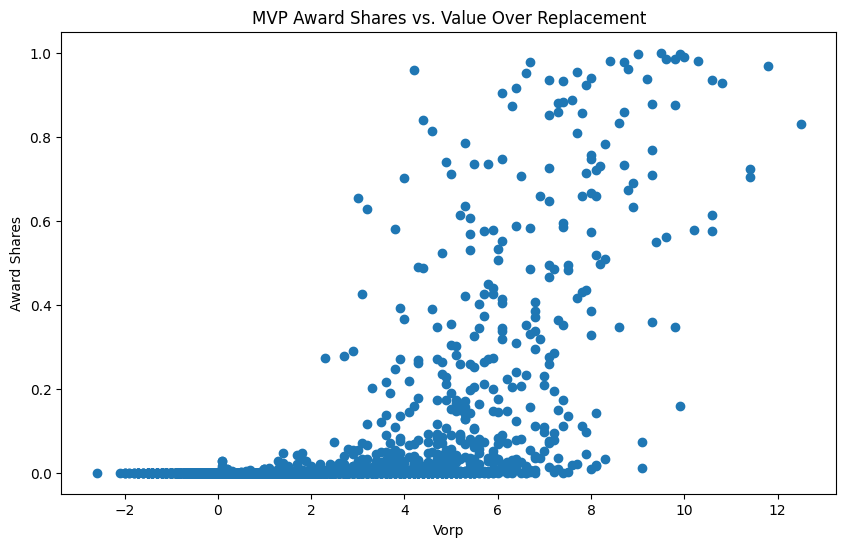

In [17]:
#Modeling different stats and their correlation to winning MVP
# - First, looking at Value Over Replacement to Award Shares
plt.figure(figsize = (10,6))
plt.scatter(data['Value_Over_Replacement'], data['Share'])
plt.title('MVP Award Shares vs. Value Over Replacement')
plt.xlabel('Vorp')
plt.ylabel('Award Shares')
plt.show()

In [18]:
mvpfactors.drop(columns=['Share', 'Team', 'Player', 'MVP', 'Season', 'Position'], inplace=True)


In [19]:

corrmatrix = mvpfactors.corr()


# get top 20 factors that impact mvp
# mvp is right now yes(1) or no(0)
top_20_factors = corrmatrix['is_mvp'].abs().sort_values(ascending=False).head(20).index

top_20_factors

corrmatrix



,Games,Minutes,Points,Rebounds,Assists,Steals,Blocks,Turnovers,FG_Pct,3P_Pct,FT_Pct,Player_Efficiency_Rating,Win_Shares,Box_Plus_Minus,Usage_Rate,Value_Over_Replacement,Win_Shares_Per_48,is_mvp
Games,1.000000,0.268511,0.200417,0.169295,0.111499,0.170961,0.110812,0.162974,0.166976,-0.033739,0.022496,0.174572,0.474284,0.221383,0.005026,0.320531,0.228666,0.046222
Minutes,0.268511,1.000000,0.817703,0.503505,0.541025,0.601504,0.248115,0.714582,0.093137,0.068864,0.142064,0.451152,0.613373,0.485252,0.330764,0.588000,0.310162,0.081052
Points,0.200417,0.817703,1.000000,0.425417,0.474916,0.484997,0.195095,0.748004,0.160278,0.113912,0.245524,0.661570,0.633979,0.564997,0.717263,0.674918,0.390103,0.154523
Rebounds,0.169295,0.503505,0.425417,1.000000,-0.067708,0.129148,0.667082,0.371041,0.485140,-0.356274,-0.300001,0.486494,0.498037,0.346598,0.124228,0.396584,0.399137,0.093805
Assists,0.111499,0.541025,0.474916,-0.067708,1.000000,0.624867,-0.197972,0.684204,-0.132333,0.229884,0.251388,0.332377,0.351630,0.433702,0.296950,0.501477,0.169753,0.099656
Steals,0.170961,0.601504,0.484997,0.129148,0.624867,1.000000,-0.005455,0.565085,-0.061061,0.126300,0.103258,0.344596,0.422790,0.485485,0.227403,0.554702,0.223526,0.085159
Blocks,0.110812,0.248115,0.195095,0.667082,-0.197972,-0.005455,1.000000,0.166981,0.411436,-0.356848,-0.326387,0.328675,0.318550,0.243550,0.011745,0.270373,0.274080,0.058043
Turnovers,0.162974,0.714582,0.748004,0.371041,0.684204,0.565085,0.166981,1.000000,0.081191,-0.041373,0.080410,0.480423,0.426218,0.398216,0.579601,0.502083,0.177521,0.113428
FG_Pct,0.166976,0.093137,0.160278,0.485140,-0.132333,-0.061061,0.411436,0.081191,1.000000,-0.359824,-0.303709,0.459912,0.409759,0.303104,-0.063257,0.277259,0.498761,0.050601
3P_Pct,-0.033739,0.068864,0.113912,-0.356274,0.229884,0.126300,-0.356848,-0.041373,-0.359824,1.000000,0.379138,-0.043995,0.001133,0.130923,0.092109,0.116084,-0.026921,0.009928


In [21]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
import seaborn as sns

In [23]:
sorted_corr_matrix = corrmatrix.loc[top_20_factors, top_20_factors]

<Axes: >

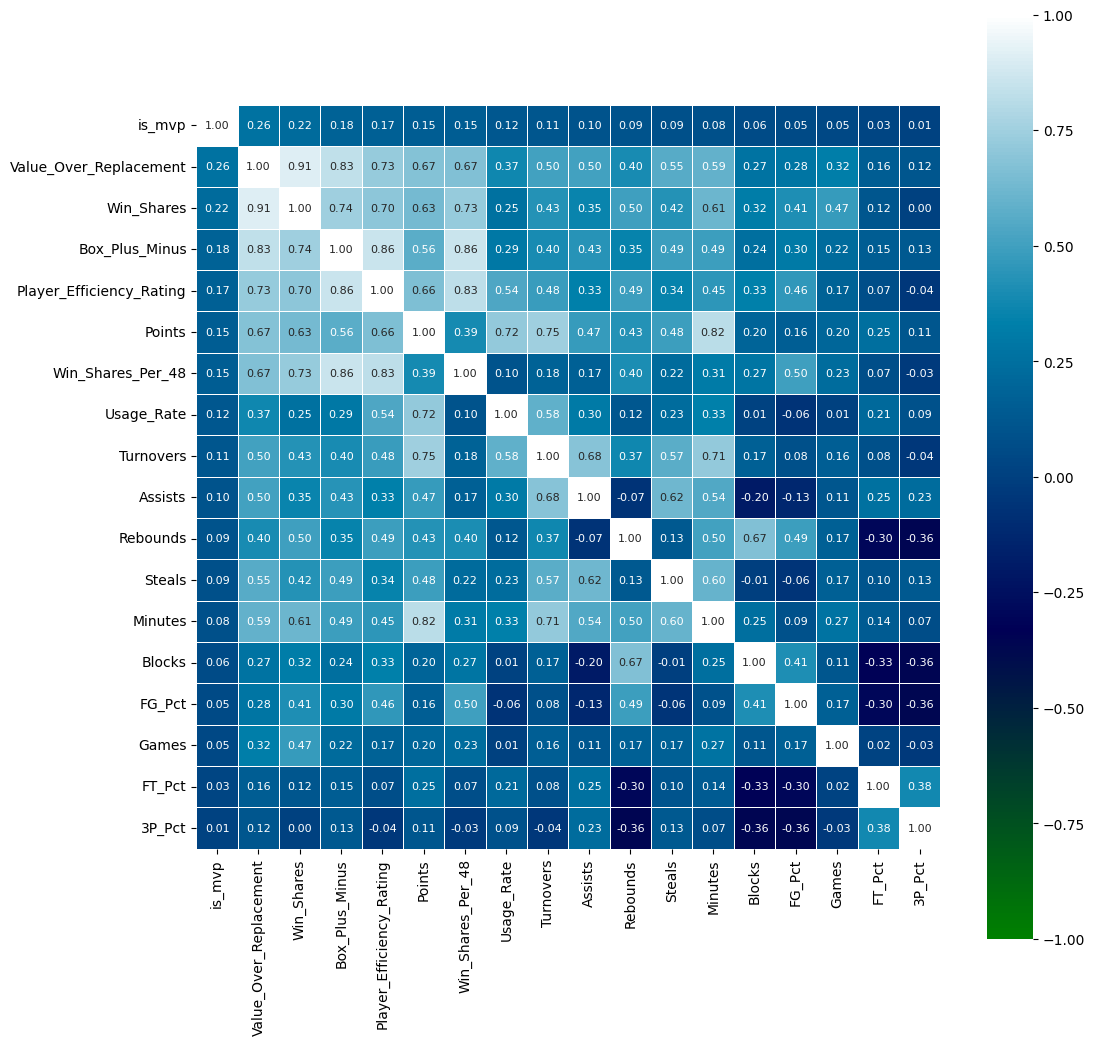

In [24]:
fig, ax = plt.subplots(figsize=(12, 12))  # Adjust size for clarity
sns.heatmap(
    sorted_corr_matrix,
    vmin=-1, vmax=1,
    cmap="ocean",
    center=0,
    annot=True,
    fmt=".2f",
    annot_kws={"fontsize": 8},
    linewidths=0.5,
    linecolor="white",
    cbar=True,
    cbar_kws={"orientation": "vertical"},
    square=True,
    xticklabels=True,
    yticklabels=True,
    ax=ax
)

In [25]:
# generate predictors by taking the top 20 factors

predictors = sorted_corr_matrix.index[:21]
predictors = predictors[predictors != 'is_mvp']
predictors

Index(['Value_Over_Replacement', 'Win_Shares', 'Box_Plus_Minus',
       'Player_Efficiency_Rating', 'Points', 'Win_Shares_Per_48', 'Usage_Rate',
       'Turnovers', 'Assists', 'Rebounds', 'Steals', 'Minutes', 'Blocks',
       'FG_Pct', 'Games', 'FT_Pct', '3P_Pct'],
      dtype='object')

# Linear/Logistic Regression

In [70]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import roc_auc_score, mean_squared_error, r2_score
from sklearn.metrics import classification_report, accuracy_score


# ─── 2) Split train/test by season ────────────────────────────────────────────
test_years = [2021, 2022, 2023, 2024]

train = data[~data['Season'].isin(test_years)]
test  = data[ data['Season'].isin(test_years)]

X_train = train[predictors]
X_test  = test[predictors]

y_train_mvp   = train['MVP']    # binary 0/1
y_test_mvp    = test['MVP']
y_train_share = train['Share']  # continuous 0–1
y_test_share  = test['Share']

print(f"Training on {len(train)} rows; testing on {len(test)} rows.\n")

# ─── 3) Logistic Regression for MVP (0/1) ─────────────────────────────────────
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train_mvp)

print("— Logistic Regression (MVP) —")
for yr in test_years:
    sub = test[test['Season'] == yr]
    y_true = sub['MVP']
    y_proba = log_model.predict_proba(sub[predictors])[:,1]
    auc = roc_auc_score(y_true, y_proba)
    # top‑1 hit?
    top1    = int(sub.iloc[y_proba.argmax()]['MVP'])
    print(f"{yr}  ROC‑AUC: {auc:.3f}, Top‑1 Acc: {top1}")

# overall classification report on all four seasons combined:
y_pred_all = log_model.predict(X_test)
y_proba_all = log_model.predict_proba(X_test)[:,1]
print("\nCombined classification report:")
print(classification_report(y_test_mvp, y_pred_all))
print(f"Overall accuracy: {accuracy_score(y_test_mvp, y_pred_all):.3f}")
print(f"Overall ROC‑AUC : {roc_auc_score(y_test_mvp, y_proba_all):.3f}")

# ─── 4) Linear Regression for MVP Vote Share ─────────────────────────────────────
lin_model = LinearRegression()
lin_model.fit(X_train, y_train_share)

y_pred_share = lin_model.predict(X_test)
mse = mean_squared_error(y_test_share, y_pred_share)
r2  = r2_score(y_test_share, y_pred_share)

print("\n— Linear Regression (Vote Share) —")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {np.sqrt(mse):.4f}")
print(f"Test R² : {r2:.4f}")

# ─── 5) Feature Importance ───────────────────────────────────────────────────
coef_log   = pd.Series(log_model.coef_[0], index=predictors)
coef_lin   = pd.Series(lin_model.coef_,    index=predictors)

print("\nTop 10 logistic coefficients (|β| for MVP):")
print(coef_log.abs().sort_values(ascending=False).head(10))

print("\nTop 10 linear coefficients (|β| for Share):")
print(coef_lin.abs().sort_values(ascending=False).head(10))


Training on 32289 rows; testing on 5043 rows.

— Logistic Regression (MVP) —
2021  ROC‑AUC: 1.000, Top‑1 Acc: 1
2022  ROC‑AUC: 1.000, Top‑1 Acc: 1
2023  ROC‑AUC: 0.999, Top‑1 Acc: 0
2024  ROC‑AUC: 1.000, Top‑1 Acc: 1

Combined classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5039
           1       0.60      0.75      0.67         4

    accuracy                           1.00      5043
   macro avg       0.80      0.87      0.83      5043
weighted avg       1.00      1.00      1.00      5043

Overall accuracy: 0.999
Overall ROC‑AUC : 1.000

— Linear Regression (Vote Share) —
Test MSE: 0.0011
Test RMSE: 0.0326
Test R² : 0.1992

Top 10 logistic coefficients (|β| for MVP):
FG_Pct                    0.948431
Steals                    0.908452
Win_Shares                0.809578
Assists                   0.559062
FT_Pct                    0.537338
Points                    0.306779
Value_Over_Replacement    0.3042

In [72]:
test_years= [2021, 2022, 2023, 2024]
test= data[data['Season'].isin(test_years)].copy()
test['predicted_share'] = lin_model.predict(test[predictors])

# 2) For each year, sort & show top 10
for yr in test_years:
    sub = test[test['Season'] == yr]
    top10 = (
        sub[['Player','Share','predicted_share']]
        .sort_values('predicted_share', ascending=False)
        .head(10)
        .reset_index(drop=True)
    )
    print(f"\n=== Top 10 Predicted Vote Shares for {yr} ===")
    print(top10.to_string(index=False))



=== Top 10 Predicted Vote Shares for 2021 ===
               Player  Share  predicted_share
         Nikola Jokić  0.961         0.189927
        Stephen Curry  0.449         0.138416
Giannis Antetokounmpo  0.345         0.131548
          Luka Dončić  0.042         0.124992
       Damian Lillard  0.038         0.105633
       Nikola Vučević  0.000         0.101504
       Nikola Vučević  0.000         0.101195
       Nikola Vučević  0.000         0.097696
          Joel Embiid  0.580         0.093949
         LeBron James  0.001         0.090761

=== Top 10 Predicted Vote Shares for 2022 ===
               Player  Share  predicted_share
         Nikola Jokić  0.875         0.224626
Giannis Antetokounmpo  0.595         0.172785
          Joel Embiid  0.706         0.152033
          Luka Dončić  0.146         0.145746
         LeBron James  0.001         0.119622
         Kevin Durant  0.001         0.112127
         Jayson Tatum  0.043         0.106005
           Trae Young  0.000    

In [73]:
sub2023 = test[test['Season']==2023]
proba2023 = log_model.predict_proba(sub2023[predictors])[:,1]
print(sub2023.assign(proba=proba2023)
              .sort_values('proba', ascending=False)
              .head(5)[['Player','proba','MVP']])

print('------')

sub2024 = test[test['Season']==2024]
proba2024 = log_model.predict_proba(sub2024[predictors])[:,1]
print(sub2024.assign(proba=proba2024)
              .sort_values('proba', ascending=False)
              .head(5)[['Player','proba','MVP']])



                      Player     proba  MVP
35026           Nikola Jokić  0.786094    0
34986            Joel Embiid  0.259454    1
35073       Domantas Sabonis  0.148808    0
34987            Luka Dončić  0.130656    0
34990  Giannis Antetokounmpo  0.106027    0
------
                        Player     proba  MVP
36097             Nikola Jokić  0.917137    1
36087              Luka Dončić  0.594763    0
36088    Giannis Antetokounmpo  0.469127    0
36089  Shai Gilgeous-Alexander  0.274175    0
36167         Domantas Sabonis  0.190814    0


In [74]:
for k in (1,3,5):
    hits = []
    for yr in test_years:
        sub = test[test['Season']==yr]
        proba = model.predict_proba(sub[predictors])[:,1]
        topk = sub.iloc[proba.argsort()[-k:]]['MVP']
        hits.append(topk.any())
    print(f"Top-{k} accuracy:", sum(hits)/len(hits))


AttributeError: 'GradientBoostingRegressor' object has no attribute 'predict_proba'

# Ridge Regression

In [41]:
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.model_selection import LeaveOneGroupOut, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# 1) Re‑build your train/test split
test_years = [2021, 2022, 2023, 2024]
train = data[~data['Season'].isin(test_years)]
test  = data[ data['Season'].isin(test_years)]

X_train, y_train = train[predictors], train['Share']
X_test,  y_test  = test[predictors],  test['Share']

# 2) Set up Leave‑One‑Season‑Out
logo   = LeaveOneGroupOut()
groups = train['Season'].values

# 3) Grid‑search over alpha with group CV
param_grid = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}
grid = GridSearchCV(
    Ridge(), 
    param_grid,
    scoring='neg_mean_squared_error',
    cv=logo.split(X_train, y_train, groups),
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train)

print("Best α (by L-OO-CV MSE):", grid.best_params_['alpha'])

# 4) Fit final Ridge with that α
ridge = Ridge(alpha=grid.best_params_['alpha'])
ridge.fit(X_train, y_train)

# 5) Evaluate on your 2021–24 hold‑out
y_pred = ridge.predict(X_test)
print("Hold‑out MSE:", mean_squared_error(y_test, y_pred))
print("Hold‑out R² :", r2_score(y_test, y_pred))

# 6) Top features
coef = pd.Series(ridge.coef_, index=predictors).abs().sort_values(ascending=False)
print("\nTop 10 features by |coef|:\n", coef.head(10))

# 7) Per‑year “Top‑10 predicted share” breakdown
for yr in test_years:
    sub = test[test['Season'] == yr].copy()
    sub['predicted_share'] = ridge.predict(sub[predictors])
    top10 = sub[['Player','Share','predicted_share']]\
            .sort_values('predicted_share', ascending=False)\
            .head(10)\
            .reset_index(drop=True)
    print(f"\n=== Top 10 Ridge‑predicted Vote Shares for {yr} ===")
    print(top10.to_string(index=False))


Fitting 40 folds for each of 5 candidates, totalling 200 fits
Best α (by L-OO-CV MSE): 0.1
Hold‑out MSE: 0.0023851816455199696
Hold‑out R² : 0.25742454597814657

Top 10 features by |coef|:
 FG_Pct                    0.184049
Win_Shares_Per_48         0.115076
FT_Pct                    0.039741
Value_Over_Replacement    0.039733
3P_Pct                    0.017736
Steals                    0.012348
Turnovers                 0.010395
Box_Plus_Minus            0.008517
Points                    0.004147
Minutes                   0.003429
dtype: float64

=== Top 10 Ridge‑predicted Vote Shares for 2021 ===
               Player  Share  predicted_share
         Nikola Jokić  0.961         0.218013
        Stephen Curry  0.449         0.160657
          Luka Dončić  0.042         0.146921
Giannis Antetokounmpo  0.345         0.146735
       Damian Lillard  0.038         0.135298
       Nikola Vučević  0.000         0.111598
       Nikola Vučević  0.000         0.105344
          Joel Embiid  0

In [42]:
# 1) Add back Player, Season, and actual vote share
results = test.copy().loc[:, ['Player','Season','Share']].rename(columns={'Share':'Award_Shares'})

# 2) Predict vote shares for the 2022 slice only
slice_2022 = results[results['Season']==2024].copy()
slice_2022['predictions'] = ridge.predict(test.loc[slice_2022.index, predictors])

# 3) Compute the true rank (Rk) by Award_Shares
slice_2022 = slice_2022.sort_values('Award_Shares', ascending=False)
slice_2022['Rank'] = range(1, len(slice_2022)+1)

# 4) Compute the predicted rank (Predicted_Rk)
slice_2022 = slice_2022.sort_values('predictions', ascending=False)
slice_2022['Predicted_Rank'] = range(1, len(slice_2022)+1)

# 5) Re‑sort by actual vote share to display
combination_2022 = slice_2022.sort_values('Rank').reset_index(drop=True)

print(combination_2022.head(10).to_string(index=False))


                 Player  Season  Award_Shares  predictions  Rank  Predicted_Rank
           Nikola Jokić    2024         0.935     0.272888     1               1
Shai Gilgeous-Alexander    2024         0.646     0.169416     2               4
            Luka Dončić    2024         0.572     0.234600     3               2
  Giannis Antetokounmpo    2024         0.194     0.195621     4               3
          Jalen Brunson    2024         0.143     0.138507     5               6
           Jayson Tatum    2024         0.087     0.121132     6               8
        Anthony Edwards    2024         0.018     0.090470     7              15
       Domantas Sabonis    2024         0.003     0.144105     8               5
           Kevin Durant    2024         0.001     0.108264     9              12
       Donovan Mitchell    2024         0.000     0.081994    10              16


# Random Forest + GradientBoostingRegressor

In [43]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import classification_report, roc_auc_score, mean_squared_error, r2_score

# ─── 1) RandomForest for MVP classification ────────────────────────────────
rf_clf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced'   # helps with the 1-vs-many imbalance
)
rf_clf.fit(X_train, y_train_mvp)

y_pred_rf    = rf_clf.predict(X_test)
y_proba_rf   = rf_clf.predict_proba(X_test)[:,1]

print("\n— RandomForestClassifier (MVP) —")
print(classification_report(y_test_mvp, y_pred_rf))
print("ROC‑AUC:", roc_auc_score(y_test_mvp, y_proba_rf))

# ─── 3) RandomForest for vote‑share regression ─────────────────────────────
rf_reg = RandomForestRegressor(
    n_estimators=200,
    random_state=42
)
rf_reg.fit(X_train, y_train_share)

y_pred_rf_reg = rf_reg.predict(X_test)

print("\n— RandomForestRegressor (Share) —")
print("MSE:", mean_squared_error(y_test_share, y_pred_rf_reg))
print("R² :", r2_score(y_test_share, y_pred_rf_reg))




— RandomForestClassifier (MVP) —
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2071
           1       0.50      0.25      0.33         4

    accuracy                           1.00      2075
   macro avg       0.75      0.62      0.67      2075
weighted avg       1.00      1.00      1.00      2075

ROC‑AUC: 0.998913568324481

— RandomForestRegressor (Share) —
MSE: 0.0006085853495783133
R² : 0.8105299262540461


In [44]:


# ─── 2) GradientBoosting for MVP classification ───────────────────────────
gb_clf = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
gb_clf.fit(X_train, y_train_mvp)

y_pred_gb  = gb_clf.predict(X_test)
y_proba_gb = gb_clf.predict_proba(X_test)[:,1]

print("\n— GradientBoostingClassifier (MVP) —")
print(classification_report(y_test_mvp, y_pred_gb))
print("ROC‑AUC:", roc_auc_score(y_test_mvp, y_proba_gb))


# ─── 4) GradientBoosting for share regression ────────────────────────
gb_reg = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
gb_reg.fit(X_train, y_train_share)

y_pred_gb_reg = gb_reg.predict(X_test)

print("\n— GradientBoostingRegressor (Share) —")
print("MSE:", mean_squared_error(y_test_share, y_pred_gb_reg))
print("R² :", r2_score(y_test_share, y_pred_gb_reg))



— GradientBoostingClassifier (MVP) —
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2071
           1       0.50      0.75      0.60         4

    accuracy                           1.00      2075
   macro avg       0.75      0.87      0.80      2075
weighted avg       1.00      1.00      1.00      2075

ROC‑AUC: 0.9987928536938676

— GradientBoostingRegressor (Share) —
MSE: 0.00101060420479756
R² : 0.6853699265951109


In [45]:
# 1) Filter to the 2022 season
slice_2022 = test[test['Season'] == 2022].copy()

# 2) Grab the top 10 by actual vote share
top10 = slice_2022.nlargest(10, 'Share').copy()

# 3) Compute RF and GB predictions
top10['predicted_rf'] = rf_reg.predict(top10[predictors])
top10['predicted_gb'] = gb_reg.predict(top10[predictors])

# 4) Display the comparison
print(top10[['Player', 'Share', 'predicted_rf', 'predicted_gb']].to_string(index=False))


               Player  Share  predicted_rf  predicted_gb
         Nikola Jokić  0.875      0.842360      1.098921
          Joel Embiid  0.706      0.417055      0.434231
Giannis Antetokounmpo  0.595      0.698145      0.700393
         Devin Booker  0.216      0.026915      0.086992
          Luka Dončić  0.146      0.184620      0.215614
         Jayson Tatum  0.043      0.083140      0.079639
            Ja Morant  0.010      0.031085      0.019729
        Stephen Curry  0.004      0.018260      0.000671
           Chris Paul  0.002      0.015275     -0.011406
         LeBron James  0.001      0.124390      0.102550


# Summary


In [46]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score, roc_auc_score,
    mean_squared_error, r2_score
)

# 1) List your models
models = [
    ('Logistic Regression',           log_model, 'clf'),
    ('Random Forest Classifier',      rf_clf,    'clf'),
    ('Gradient Boosting Classifier',  gb_clf,    'clf'),
    ('Linear Regression',             lin_model, 'reg'),
    ('Ridge Regression',              ridge,     'reg'),
    ('Random Forest Regressor',       rf_reg,    'reg'),
    ('Gradient Boosting Regressor',   gb_reg,    'reg'),
]

# 2) Compute metrics
rows = []
for name, model, mtype in models:
    r = {'Model': name}
    if mtype == 'clf':
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:,1]
        r.update({
            'Precision': precision_score(y_test_mvp, y_pred, zero_division=0),
            'Recall':    recall_score(   y_test_mvp, y_pred, zero_division=0),
            'F1':        f1_score(       y_test_mvp, y_pred, zero_division=0),
            'Accuracy':  accuracy_score( y_test_mvp, y_pred),
            'ROC_AUC':   roc_auc_score(  y_test_mvp, y_proba),
            'MSE':       np.nan,
            'RMSE':      np.nan,
            'R2':        np.nan,
        })
    else:
        y_pred = model.predict(X_test)
        mse  = mean_squared_error(y_test_share, y_pred)
        r.update({
            'Precision': np.nan,
            'Recall':    np.nan,
            'F1':        np.nan,
            'Accuracy':  np.nan,
            'ROC_AUC':   np.nan,
            'MSE':       mse,
            'RMSE':      np.sqrt(mse),
            'R2':        r2_score(y_test_share, y_pred),
        })
    rows.append(r)

# 3) Build and display DataFrame
df_summary = pd.DataFrame(rows)
# order columns
df_summary = df_summary[[
    'Model','Precision','Recall','F1','Accuracy','ROC_AUC','MSE','RMSE','R2'
]]
display(df_summary)




,Model,Precision,Recall,F1,Accuracy,ROC_AUC,MSE,RMSE,R2
0,Logistic Regression,0.6,0.75,0.666667,0.998554,0.999034,NaN,NaN,NaN
1,Random Forest Classifier,0.5,0.25,0.333333,0.998072,0.998914,NaN,NaN,NaN
2,Gradient Boosting Classifier,0.5,0.75,0.600000,0.998072,0.998793,NaN,NaN,NaN
3,Linear Regression,NaN,NaN,NaN,NaN,NaN,0.002385,0.048841,0.257331
4,Ridge Regression,NaN,NaN,NaN,NaN,NaN,0.002385,0.048838,0.257425
5,Random Forest Regressor,NaN,NaN,NaN,NaN,NaN,0.000609,0.024670,0.810530
6,Gradient Boosting Regressor,NaN,NaN,NaN,NaN,NaN,0.001011,0.031790,0.685370


In [ ]:
class NBADataScraper2025:
    def __init__(self):
        self.base_url = "https://www.basketball-reference.com"
        self.headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }
        
    def get_page_content(self, url):
        """Fetch page content with error handling and rate limiting"""
        try:
            logging.info(f"Fetching URL: {url}")
            time.sleep(3)  # Rate limiting
            response = requests.get(url, headers=self.headers)
            response.raise_for_status()
            return BeautifulSoup(response.content, 'html.parser')
        except requests.exceptions.RequestException as e:
            logging.error(f"Request error for {url}: {str(e)}")
            return None
        except Exception as e:
            logging.error(f"Unexpected error fetching {url}: {str(e)}")
            return None

    def get_basic_stats(self, year):
        """Extract basic statistics for a given season"""
        url = f"{self.base_url}/leagues/NBA_{year}_per_game.html"
        soup = self.get_page_content(url)
        if not soup:
            logging.error(f"Failed to get basic stats page for {year}")
            return None
            
        try:
            stats_table = soup.find('table', {'id': 'per_game_stats'})
            if not stats_table:
                logging.error(f"Could not find basic stats table for {year}")
                return None
                
            # Convert table to DataFrame using StringIO
            df = pd.read_html(str(stats_table))[0]
            
            # Print available columns for debugging
            logging.info(f"Available columns for {year}: {df.columns.tolist()}")
            
            # Clean up the DataFrame
            df = df[df['Player'].notna()]  # Remove rows where Player is NaN
            df = df[~df['Player'].str.contains('Player')]  # Remove header rows
            
            # Map column names to handle different naming conventions
            column_mapping = {
                'Tm': 'Team',
                'Pos': 'Position',
                'G': 'Games',
                'MP': 'Minutes',
                'PTS': 'Points',
                'TRB': 'Rebounds',
                'AST': 'Assists',
                'STL': 'Steals',
                'BLK': 'Blocks',
                'TOV': 'Turnovers',
                'FG%': 'FG_Pct',
                '3P%': '3P_Pct',
                'FT%': 'FT_Pct'
            }
            
            # Rename columns if they exist
            for old_col, new_col in column_mapping.items():
                if old_col in df.columns:
                    df = df.rename(columns={old_col: new_col})
            
            # Select relevant columns (using new names)
            columns = ['Player', 'Team', 'Position', 'Season', 'Games', 'Minutes', 'Points', 
                      'Rebounds', 'Assists', 'Steals', 'Blocks', 'Turnovers', 
                      'FG_Pct', '3P_Pct', 'FT_Pct']
            
            # Only select columns that exist in the DataFrame
            available_columns = [col for col in columns if col in df.columns]
            if not available_columns:
                logging.error(f"No matching columns found for {year}")
                return None
                
            df = df[available_columns]
            logging.info(f"Successfully extracted basic stats for {year}")
            return df
        except Exception as e:
            logging.error(f"Error extracting basic stats for {year}: {str(e)}")
            return None

    def get_advanced_stats(self, year):
        """Extract advanced statistics for a given season"""
        url = f"{self.base_url}/leagues/NBA_{year}_advanced.html"
        soup = self.get_page_content(url)
        if not soup:
            logging.error(f"Failed to get advanced stats page for {year}")
            return None
            
        try:
            # Look for the table with class 'stats_table'
            stats_table = soup.find('table', {'class': 'stats_table'})
            if not stats_table:
                logging.error(f"Could not find advanced stats table for {year}")
                return None
                
            # Convert table to DataFrame using StringIO
            df = pd.read_html(str(stats_table))[0]
            
            # Print available columns for debugging
            logging.info(f"Available advanced columns for {year}: {df.columns.tolist()}")
            
            # Clean up the DataFrame
            df = df[df['Player'].notna()]  # Remove rows where Player is NaN
            df = df[~df['Player'].str.contains('Player')]  # Remove header rows
            
            # Map column names to handle different naming conventions
            column_mapping = {
                'PER': 'Player_Efficiency_Rating',
                'WS': 'Win_Shares',
                'BPM': 'Box_Plus_Minus',
                'USG%': 'Usage_Rate',
                'VORP': 'Value_Over_Replacement',
                'WS/48': 'Win_Shares_Per_48'
            }
            
            # Rename columns if they exist
            for old_col, new_col in column_mapping.items():
                if old_col in df.columns:
                    df = df.rename(columns={old_col: new_col})
            
            # Select relevant columns (using new names)
            columns = ['Player', 'Player_Efficiency_Rating', 'Win_Shares', 
                      'Box_Plus_Minus', 'Usage_Rate', 'Value_Over_Replacement', 
                      'Win_Shares_Per_48']
            
            # Only select columns that exist in the DataFrame
            available_columns = [col for col in columns if col in df.columns]
            if not available_columns:
                logging.error(f"No matching advanced columns found for {year}")
                return None
                
            df = df[available_columns]
            logging.info(f"Successfully extracted advanced stats for {year}")
            return df
        except Exception as e:
            logging.error(f"Error extracting advanced stats for {year}: {str(e)}")
            return None

    def scrape_season(self, year):
        """Scrape all data for a given season"""
        logging.info(f"Starting to scrape data for {year} season...")
        
        # Get basic stats
        basic_stats = self.get_basic_stats(year)
        if basic_stats is None:
            logging.error(f"Failed to get basic stats for {year}")
            return None
            
        # Get advanced stats
        advanced_stats = self.get_advanced_stats(year)
        if advanced_stats is None:
            logging.error(f"Failed to get advanced stats for {year}")
            return None
            
        try:
            # Merge basic and advanced stats
            merged_stats = pd.merge(basic_stats, advanced_stats, on='Player', how='left')
            
            # Add Season column
            merged_stats['Season'] = year
            
            logging.info(f"Successfully merged all data for {year}")
            return merged_stats
        except Exception as e:
            logging.error(f"Error merging data for {year}: {str(e)}")
            return None

In [ ]:
def main():
    scraper = NBADataScraper()
    season_year = 2025  # 2024–25 NBA season
    final_df = scraper.scrape_season(season_year)

    if final_df is not None:
        # Save to CSV
        output_file = f'nba_mvp_data_{season_year}.csv'
        final_df.to_csv(output_file, index=False)
        logging.info(f"Data successfully saved to {output_file}")

        # Print some basic statistics about the dataset
        logging.info(f"\nDataset Statistics:")
        logging.info(f"Total number of players in {season_year}: {len(final_df)}")
        logging.info(f"MVP winner for {season_year}: {final_df[final_df['MVP'] == 1]['Player'].values[0]}")
        logging.info(f"Average MVP Share: {final_df['Share'].mean():.3f}")
    else:
        logging.error(f"Failed to scrape data for season {season_year}")

In [68]:
if __name__ == "__main__":
    main() 

2025-05-10 23:00:55,094 - INFO - Scraping season 2025…
2025-05-10 23:00:55,094 - INFO - Fetching URL: https://www.basketball-reference.com/awards/awards_2025.html
2025-05-10 23:00:58,576 - ERROR - No MVP table for 2025
2025-05-10 23:00:58,577 - INFO - Fetching URL: https://www.basketball-reference.com/leagues/NBA_2025_per_game.html
C:\Users\chris\AppData\Local\Temp\ipykernel_235668\1286478929.py:96: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]
2025-05-10 23:01:03,941 - INFO - Fetching URL: https://www.basketball-reference.com/leagues/NBA_2025_advanced.html
C:\Users\chris\AppData\Local\Temp\ipykernel_235668\1286478929.py:134: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]
2025

In [52]:
data2025 = pd.read_csv('nba_2025_season.csv')
data2025.head()

,Season,Player,Team,Position,Games,Minutes,Points,Rebounds,Assists,Steals,...,Turnovers,FG_Pct,3P_Pct,FT_Pct,Player_Efficiency_Rating,Win_Shares,Box_Plus_Minus,Usage_Rate,Value_Over_Replacement,Win_Shares_Per_48
0,2025,Shai Gilgeous-Alexander,OKC,PG,76.0,34.2,32.7,5.0,6.4,1.7,...,2.4,0.519,0.375,0.898,30.7,16.7,11.5,34.8,8.9,0.309
1,2025,Giannis Antetokounmpo,MIL,PF,67.0,34.2,30.4,11.9,6.5,0.9,...,3.1,0.601,0.222,0.617,30.5,11.5,9.5,35.2,6.6,0.241
2,2025,Nikola Jokić,DEN,C,70.0,36.7,29.6,12.7,10.2,1.8,...,3.3,0.576,0.417,0.800,32.0,16.4,13.3,29.5,9.8,0.307
3,2025,Luka Dončić,2TM,PG,50.0,35.4,28.2,8.2,7.7,1.8,...,3.6,0.450,0.368,0.782,24.1,5.9,6.7,33.9,3.9,0.160
4,2025,Luka Dončić,2TM,PG,50.0,35.4,28.2,8.2,7.7,1.8,...,3.6,0.450,0.368,0.782,24.2,2.5,6.9,33.1,1.8,0.155


In [53]:
data2025.fillna(0, inplace=True)

In [69]:
data2025 = data2025[(data2025['Games'] >= 30) & (data2025['Minutes'] > 10) & (data2025['Points'] > 5)]

In [75]:
predict_2025 = data2025
X_2025 = predict_2025[predictors]

In [ ]:
#retrain
X_train = train[predictors]
y_train_mvp   = train['MVP']   

log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train_mvp)

#predict
predict_2025['Predicted_Prob_MVP'] = log_model.predict_proba(X_2025)[:, 1]
top_preds = predict_2025[['Player', 'Season', 'Predicted_Prob_MVP']]
top_preds = top_preds.sort_values(by='Predicted_Prob_MVP', ascending=False)
print(top_preds.head(10))
print("\nMost likely MVP (Logistic):")
print(top_preds.iloc[0])



                      Player  Season  Predicted_Prob_MVP
2               Nikola Jokić    2025            0.955145
0    Shai Gilgeous-Alexander    2025            0.751309
1      Giannis Antetokounmpo    2025            0.399664
86          Domantas Sabonis    2025            0.033832
13              Jayson Tatum    2025            0.024400
35        Karl-Anthony Towns    2025            0.018124
136              Ivica Zubac    2025            0.017561
93         Tyrese Haliburton    2025            0.015756
17             Jalen Brunson    2025            0.009178
34              LeBron James    2025            0.009097

Most likely MVP (Logistic):
Player                Nikola Jokić
Season                        2025
Predicted_Prob_MVP        0.955145
Name: 2, dtype: object


In [80]:
#retrain
X_train = train[predictors]
y_train_share = train['Share']

rf_clf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced'
)

rf_reg.fit(X_train, y_train_share)
#
y_pred_rf_reg = rf_reg.predict(X_test)
predict_2025['Predicted_Share_RF'] = rf_reg.predict(X_2025)
top_preds_rf = predict_2025[['Player', 'Team', 'Season', 'Predicted_Share_RF']]
top_preds_rf = top_preds_rf.sort_values(by='Predicted_Share_RF', ascending=False)

print("\nTop 10 MVP Candidates for 2025 (Random Forest):")
print(top_preds_rf.head(10))


Top 10 MVP Candidates for 2025 (Random Forest):
                      Player Team  Season  Predicted_Share_RF
2               Nikola Jokić  DEN    2025            0.847210
0    Shai Gilgeous-Alexander  OKC    2025            0.836885
1      Giannis Antetokounmpo  MIL    2025            0.489780
13              Jayson Tatum  BOS    2025            0.082320
36         Victor Wembanyama  SAS    2025            0.065230
118             Jimmy Butler  GSW    2025            0.059905
3                Luka Dončić  2TM    2025            0.052595
33             Stephen Curry  GSW    2025            0.049205
86          Domantas Sabonis  SAC    2025            0.046370
38                Trae Young  ATL    2025            0.041905
